### LIBRARIES TO INSTALL

In [ ]:
pip install seaborn

In [ ]:
pip install scikit-learn

In [ ]:
pip install pylab

In [ ]:
pip install tqdm

In [ ]:
pip install torch

### IMPORTS

In [1]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

### DOWNLOAD AND LOAD DATA

In [2]:
import os
from io import BytesIO
import requests
from zipfile import ZipFile
from urllib.request import urlopen
import zipfile

url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'

df = pd.read_csv(url, compression="zip")

df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


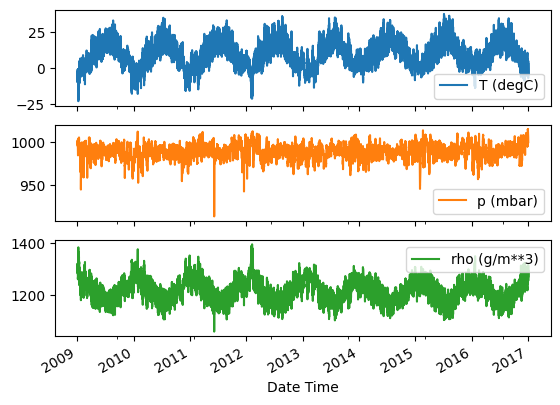

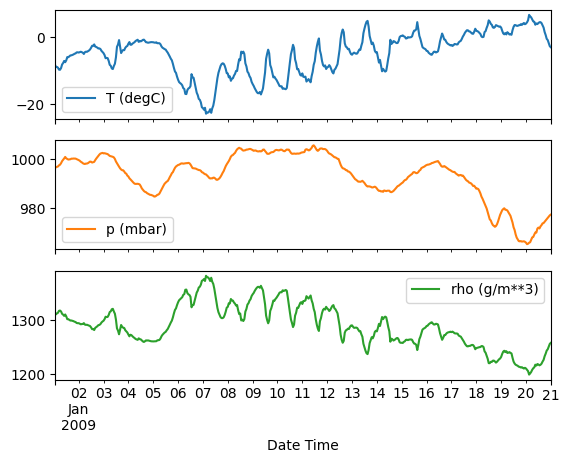

In [3]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [13]:
target_col = 'T (degC)'
sequence_length = 24
df = df[[target_col]]
df.describe().transpose()
target_index = df.columns.get_loc(target_col)
print(target_index)


0


In [14]:
df.transpose()

,5,11,17,23,29,35,41,47,53,59,...,420491,420497,420503,420509,420515,420521,420527,420533,420539,420545
T (degC),-8.05,-8.88,-8.81,-9.05,-9.63,-9.67,-9.17,-8.1,-7.66,-7.04,...,4.15,4.97,2.44,1.29,-0.42,-0.98,-1.4,-2.75,-2.89,-3.93


# DATA NORMALISATION

In [15]:
scaler = StandardScaler()
data = scaler.fit_transform(df)
print(data)

mean_temp = scaler.mean_[0]
print(f"Average temperature: {mean_temp:.2f} °C")

std_temp = scaler.scale_[0]
print(f"Standard deviation: {std_temp:.2f}")

[[-2.07762187]
 [-2.1761578 ]
 [-2.16784754]
 ...
 [-1.44841656]
 [-1.46503708]
 [-1.58850378]]
Average temperature: 9.45 °C
Standard deviation: 8.42


# DATASET CLASS

In [16]:
class JenaDataset(Dataset):
    def __init__(self, data, sequence_length, target_index, pred_len=3):
        self.data = data
        self.seq_len = sequence_length
        self.target_idx = target_index
        self.pred_len = pred_len

    def __len__(self):
       return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        y = self.data[idx + self.seq_len : idx + self.seq_len + self.pred_len, self.target_idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# SPLITTING DATA

In [18]:
split_ratio = 0.8
split_index = int(len(data) * split_ratio)
train_dataset = JenaDataset(data[:split_index], sequence_length, target_index)
val_dataset = JenaDataset(data[split_index:], sequence_length, target_index)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# WEATHER LSTM MODEL

In [19]:
class WeatherLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(WeatherLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 3)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1])  # Only the last timestep
        return out.squeeze()

# MODEL INITIALIZATION

In [ ]:
input_size = data.shape[1]
print(input_size)
model = WeatherLSTM(input_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# TRAINING LOOP

In [ ]:
def train_model(model, train_loader, val_loader, epochs=100):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb)
                loss = loss_fn(pred, yb)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

### TRAINING RUN

In [24]:
train_model(model, train_loader, val_loader, epochs=100)

Batch xb shape: torch.Size([64, 24, 1])
Batch yb shape: torch.Size([64, 3])
Batch xb shape: torch.Size([64, 24, 1])
Batch yb shape: torch.Size([64, 3])
Batch xb shape: torch.Size([64, 24, 1])
Batch yb shape: torch.Size([64, 3])
Batch xb shape: torch.Size([64, 24, 1])
Batch yb shape: torch.Size([64, 3])
Batch xb shape: torch.Size([64, 24, 1])
Batch yb shape: torch.Size([64, 3])
Batch xb shape: torch.Size([64, 24, 1])
Batch yb shape: torch.Size([64, 3])
Batch xb shape: torch.Size([64, 24, 1])
Batch yb shape: torch.Size([64, 3])
Batch xb shape: torch.Size([64, 24, 1])
Batch yb shape: torch.Size([64, 3])
Batch xb shape: torch.Size([64, 24, 1])
Batch yb shape: torch.Size([64, 3])
Batch xb shape: torch.Size([64, 24, 1])
Batch yb shape: torch.Size([64, 3])
Batch xb shape: torch.Size([64, 24, 1])
Batch yb shape: torch.Size([64, 3])
Batch xb shape: torch.Size([64, 24, 1])
Batch yb shape: torch.Size([64, 3])
Batch xb shape: torch.Size([64, 24, 1])
Batch yb shape: torch.Size([64, 3])
Batch xb sha

KeyboardInterrupt: 

### EXAMPLE

In [27]:
recent_data = df.tail(sequence_length).values
print(df.tail(sequence_length))

recent_scaled = scaler.transform(recent_data)

# Convert to tensor and add batch dimension
x_input = torch.tensor(recent_scaled, dtype=torch.float32).unsqueeze(0)  # shape: (1, seq_len, features)

# Predict
model.eval()
with torch.no_grad():
    pred_scaled = model(x_input).squeeze(0)  # usuń batch dim, shape: (3,)

# Inverse transform to get temperature in Celsius
pred_celsius = pred_scaled.numpy() * scaler.scale_[target_index] + scaler.mean_[target_index]

# Wyświetl prognozy po kolei
for i, temp in enumerate(pred_celsius, 1):
    print(f"Predicted temperature for step {i}: {temp:.2f} °C")


        T (degC)
420407     -4.17
420413     -4.26
420419     -5.05
420425     -4.67
420431     -4.47
420437     -4.90
420443     -5.17
420449     -6.20
420455     -6.84
420461     -6.31
420467     -5.02
420473     -3.31
420479     -0.71
420485      1.97
420491      4.15
420497      4.97
420503      2.44
420509      1.29
420515     -0.42
420521     -0.98
420527     -1.40
420533     -2.75
420539     -2.89
420545     -3.93
Predicted temperature for step 1: -4.20 °C
Predicted temperature for step 2: -4.40 °C
Predicted temperature for step 3: -4.45 °C


c:\Users\piotr\OneDrive\Dokumenty\Uni\time-series-forecasting-rpi\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# EXPORT TO RASPBERRY PI

In [ ]:
model.eval()

dummy_input = torch.randn(64, sequence_length, input_size)

traced_model = torch.jit.trace(model, dummy_input)

traced_model.save("weather_lstm_model.pt")
